# Step 4: Detect Four Point Sources (RXJ1131)

This notebook detects the four brightest point-like sources in the HST cutout,
reports their pixel positions, converts them to arcsec coordinates using `pix_scale=0.05`
assuming image center is `(0, 0)`, and estimates rough fluxes with aperture photometry.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

In [2]:
# Config
pix_scale = 0.05  # arcsec / pixel (HST)

CANDIDATE_DATA_DIRS = [
    "../../Data/RXJ1131",
    "/mnt/d/lensing/Herculens/Data/RXJ1131",
]

DATA_DIR = None
for d in CANDIDATE_DATA_DIRS:
    if os.path.exists(d):
        DATA_DIR = d
        break
if DATA_DIR is None:
    raise FileNotFoundError(f"Cannot find RXJ1131 directory. Tried: {CANDIDATE_DATA_DIRS}")

raw_data_path = os.path.join(DATA_DIR, "j8oi74010_drc.fits")
data_path = os.path.join(DATA_DIR, "j8oi74010_drc_cut_x2116_y3377_200_scierr_corner5.fits")
mask_path = os.path.join(DATA_DIR, "mask.fits")

print("DATA_DIR:", DATA_DIR)
print("raw_data_path:", raw_data_path)
print("data_path:", data_path)
print("mask_path:", mask_path)


DATA_DIR: ../../Data/RXJ1131
raw_data_path: ../../Data/RXJ1131/j8oi74010_drc.fits
data_path: ../../Data/RXJ1131/j8oi74010_drc_cut_x2116_y3377_200_scierr_corner5.fits
mask_path: ../../Data/RXJ1131/mask.fits


In [3]:
# Load image + error + masks + exposure time
with fits.open(raw_data_path, memmap=True) as hdul_raw:
    hdr0 = hdul_raw[0].header
    hdr_sci = hdul_raw["SCI"].header if "SCI" in hdul_raw else hdul_raw[1].header
    exposure_time = float(
        hdr0.get("EXPTIME", hdr0.get("TEXPTIME", hdr_sci.get("EXPTIME", hdr_sci.get("TEXPTIME", 1.0))))
    )

with fits.open(data_path, memmap=True) as hdul:
    if "SCI" in hdul:
        data = np.array(hdul["SCI"].data, dtype=float)
    else:
        data = np.array(hdul[0].data, dtype=float)

    if "ERR" in hdul:
        err = np.array(hdul["ERR"].data, dtype=float)
    elif len(hdul) > 1 and hdul[1].data is not None:
        err = np.array(hdul[1].data, dtype=float)
    else:
        raise ValueError(f"Cannot find ERR extension in {data_path}")

mask = np.array(fits.getdata(mask_path), dtype=bool)
mask_out = np.ones_like(data, dtype=bool)

valid = np.isfinite(data) & np.isfinite(err) & (err > 0) & mask & mask_out

if data.shape != err.shape or data.shape != mask.shape or data.shape != mask_out.shape:
    raise ValueError(
        f"Shape mismatch: data={data.shape}, err={err.shape}, mask={mask.shape}, mask_out={mask_out.shape}"
    )

print("shape:", data.shape)
print("exposure_time:", exposure_time)
print("valid pixels:", int(valid.sum()))


shape: (200, 200)
exposure_time: 1980.0
valid pixels: 11967


In [4]:
# Build working image for peak finding
work = data.copy()
median_fill = np.nanmedian(data[valid])
work[~valid] = median_fill

mean, med, std = sigma_clipped_stats(work[valid], sigma=3.0)
print("sigma-clipped stats:", {"mean": float(mean), "median": float(med), "std": float(std)})

# STARRED-style DAOStarFinder baseline
daofind = DAOStarFinder(
    fwhm=2.5,           # in pixels
    threshold=5.0*std,  # detection threshold
    exclude_border=True,
)

sources = daofind(work - med)
if sources is None or len(sources) == 0:
    raise RuntimeError("No sources found. Try lower threshold or adjust fwhm.")

print("detected sources:", len(sources))
sources.sort("peak")
sources = sources[::-1]  # brightest first
sources[:8]

sigma-clipped stats: {'mean': 0.25995746608019643, 'median': 0.19945790618658066, 'std': 0.18791355940419205}
detected sources: 7


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
4,126.55172872698627,132.0424812158331,0.6118403669701751,0.06734923864587225,0.07353840942267412,25,195.76102183014154,1379.4736630097032,-7.849283533297991,-5.6434095468182175
7,104.75962744189346,141.35109939596157,0.5808008271413726,0.08607795366373096,0.232556206449567,25,183.79372141510248,1515.926703132689,-7.951695507866456,-5.484976130184482
6,79.49591978891023,139.7995463931026,0.7449017688715446,-0.1377204107840318,-0.09844950189287238,25,89.2185795083642,536.0981523171067,-6.823110776038143,-4.709886349732051
1,94.97813819587626,77.3662570442843,0.726637158328026,0.15962367601349825,0.13718803750314412,25,24.989316202700138,163.64718893915415,-5.534771373961891,-3.314874691056506
3,131.17160578937592,128.17679939606214,0.4672241650585734,0.96050234236193,0.24089978713724414,25,3.9599897637963295,88.2087208405137,-4.863778810496312,-0.2785030783738067
5,74.70577092795571,136.2440170505962,0.639457997895895,-0.5613621809509627,-0.19057721116334692,25,3.0020503774285316,54.08956591039896,-4.33278374018887,-0.059573871043337445
2,137.82277722684648,117.66354636217177,0.6154572016269694,-0.4771560877988454,0.5359144328617538,25,1.9210183396935463,27.224589325487614,-3.5874033431981096,-0.06638379471891284


In [5]:
# Select 4 distinct brightest peaks with a minimum separation
N_SELECT = 4
MIN_SEP_PIX = 4.0

selected_rows = []
selected_pos = []
for row in sources:
    x = float(row["xcentroid"])
    y = float(row["ycentroid"])
    if all(np.hypot(x - sx, y - sy) >= MIN_SEP_PIX for sx, sy in selected_pos):
        selected_rows.append(row)
        selected_pos.append((x, y))
    if len(selected_rows) == N_SELECT:
        break

if len(selected_rows) < N_SELECT:
    raise RuntimeError(f"Only found {len(selected_rows)} distinct sources; expected {N_SELECT}.")

positions = np.array(selected_pos)
positions

array([[126.55172873, 132.04248122],
       [104.75962744, 141.3510994 ],
       [ 79.49591979, 139.79954639],
       [ 94.9781382 ,  77.36625704]])

In [6]:
# Rough flux estimation with aperture photometry
# flux ~ aperture_sum - local_background * aperture_area
r_ap = 3.0
r_in, r_out = 5.0, 8.0

ap = CircularAperture(positions, r=r_ap)
an = CircularAnnulus(positions, r_in=r_in, r_out=r_out)

phot_ap = aperture_photometry(work, ap)
phot_an = aperture_photometry(work, an)

x0 = (work.shape[1] - 1) / 2.0
y0 = (work.shape[0] - 1) / 2.0

rows = []
for i, (x, y) in enumerate(positions, start=1):
    bkg = float(phot_an["aperture_sum"][i-1] / an.area)
    flux = float(phot_ap["aperture_sum"][i-1] - bkg * ap.area)

    x_arcsec = (x - x0) * pix_scale
    y_arcsec = (y - y0) * pix_scale

    rows.append({
        "id": i,
        "x_pix": x,
        "y_pix": y,
        "x_pix_1based": x + 1.0,
        "y_pix_1based": y + 1.0,
        "x_arcsec_centered": x_arcsec,
        "y_arcsec_centered": y_arcsec,
        "flux_aperture_bgsub": flux,
        "local_bkg_per_pix": bkg,
    })

result = pd.DataFrame(rows).sort_values("flux_aperture_bgsub", ascending=False).reset_index(drop=True)
result

,id,x_pix,y_pix,x_pix_1based,y_pix_1based,x_arcsec_centered,y_arcsec_centered,flux_aperture_bgsub,local_bkg_per_pix
0,2,104.759627,141.351099,105.759627,142.351099,0.262981,2.092555,1518.580885,1.921617
1,1,126.551729,132.042481,127.551729,133.042481,1.352586,1.627124,1370.498025,1.700035
2,3,79.495920,139.799546,80.495920,140.799546,-1.000204,2.014977,534.315976,1.317783
3,4,94.978138,77.366257,95.978138,78.366257,-0.226093,-1.106687,155.710131,0.695736


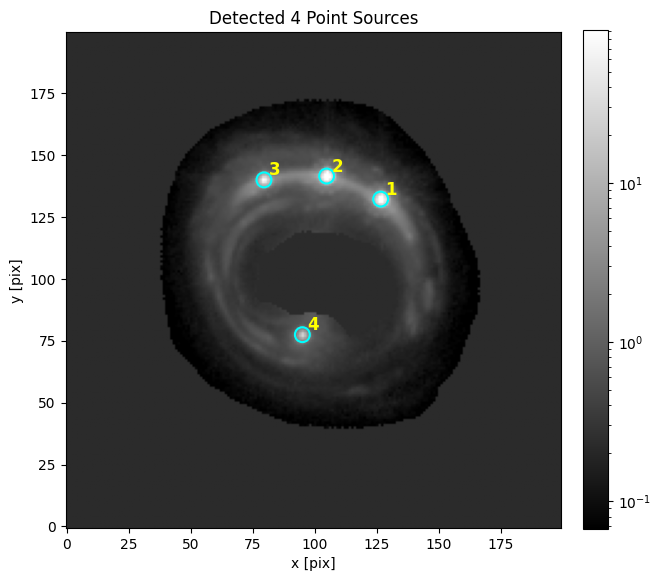

In [7]:
# Plot detections
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(work, origin="lower", cmap="gray", norm=colors.LogNorm(vmin=np.percentile(work[valid], 5), vmax=np.percentile(work[valid], 99.9)))
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ap.plot(ax=ax, color="cyan", lw=1.5)
for _, r in result.iterrows():
    ax.text(r["x_pix"] + 2, r["y_pix"] + 2, f"{int(r['id'])}", color="yellow", fontsize=12, weight="bold")

ax.set_title("Detected 4 Point Sources")
ax.set_xlabel("x [pix]")
ax.set_ylabel("y [pix]")
plt.show()

In [8]:
# Optional: save result table
out_csv = "point_sources_rxj1131_4sources.csv"
result.to_csv(out_csv, index=False)
out_csv

'point_sources_rxj1131_4sources.csv'